In [1]:
# Importing Libraries.
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

C:\Users\dhayanesh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [4]:
# Setting Device Agnostic Code.
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-45,45))
])

In [6]:
# Downloading MNIST dataset.

train_data = datasets.MNIST(
    root="MNIST_dataset",
    train=True,
    download=False,
    transform=transform,
    target_transform=None
)

test_data = datasets.MNIST(
    root="MNIST_dataset",
    train=False,
    download=False,
    transform=transform
)

In [7]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [8]:
classes = train_data.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

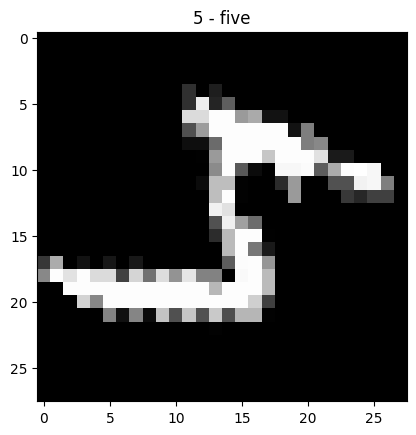

In [9]:
# Visualizing a sample from training data.
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(classes[label])
plt.show()

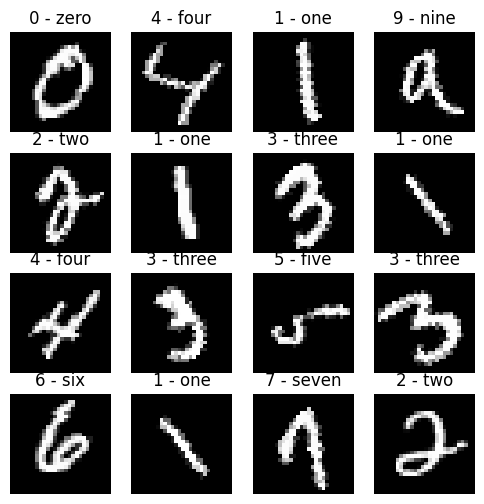

In [10]:
# Plot more images
fig = plt.figure(figsize=(6,6))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    img, label = train_data[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label])
    plt.axis(False)

In [11]:
from torch.utils.data import DataLoader

In [12]:
BATCH_SIZE = 16 # hyper parameter.

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [13]:
len(train_dataloader), len(test_dataloader)

(3750, 625)

In [14]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

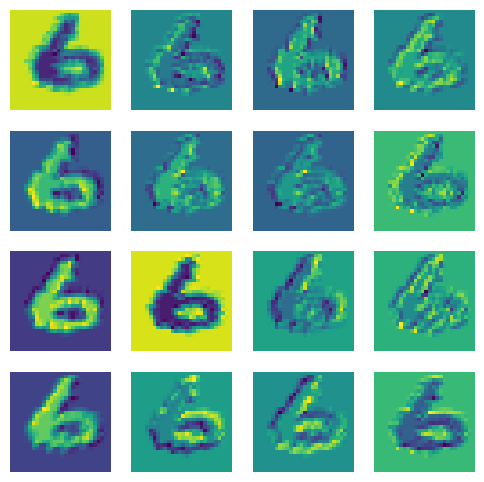

In [15]:
# What it does look like after convolving an image?
idx = 1
image, label = train_feature_batch[idx], train_label_batch[idx]
conv = nn.Conv2d(
    in_channels=1,
    out_channels=16,
    kernel_size=3,
    stride=1,
    padding=1,
)
output_feature = conv(image)
fig = plt.figure(figsize=(6,6))
rows,cols = 4,4
for i in range(rows * cols):
    img = output_feature[i].detach().numpy()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis(False)

In [16]:
# MNIST model.
class MNIST_MODEL_V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=5,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=5,
            out_channels=10,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.conv3 = nn.Conv2d(
            in_channels=10,
            out_channels=20,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.relu = nn.ReLU()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=20*28*28,
                      out_features=10)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.classifier(x)
        return x

model_1 = MNIST_MODEL_V1()
model_1.to(device)
model_1

MNIST_MODEL_V1(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=15680, out_features=10, bias=True)
  )
)

In [17]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01)

In [19]:
from tqdm.auto import tqdm

In [20]:
from helper_functions import accuracy_fn

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [21]:
def print_train_time(start, end, device):
    print(f"Time: {round(end-start, 3)} seconds on device: {device}")

In [23]:
torch.manual_seed(55)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.15860 | Train accuracy: 95.24%



 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.73s/it]

Test loss: 0.12553 | Test accuracy: 96.00%

Epoch: 1
Train loss: 0.14028 | Train accuracy: 95.76%



 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:39, 33.05s/it]

Test loss: 0.12214 | Test accuracy: 96.41%

Epoch: 2
Train loss: 0.12596 | Train accuracy: 96.17%



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:06, 33.23s/it]

Test loss: 0.10970 | Test accuracy: 96.51%

Epoch: 3
Train loss: 0.11483 | Train accuracy: 96.56%



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:13<00:33, 33.51s/it]

Test loss: 0.10294 | Test accuracy: 96.88%

Epoch: 4
Train loss: 0.10781 | Train accuracy: 96.67%


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.51s/it]

Test loss: 0.10933 | Test accuracy: 96.73%

Time: 167.543 seconds on device: cuda


In [24]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [25]:
torch.manual_seed(42)
result_model_1 = eval_model(
    model_1,
    test_dataloader,
    loss_fn,
    accuracy_fn,
)
result_model_1

{'model_name': 'MNIST_MODEL_V1',
 'model_loss': 0.10753608494997025,
 'model_acc': 96.54}

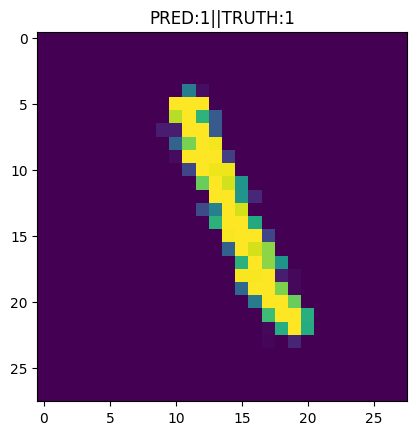

In [27]:
idx = 5
test_feature_batch, test_label_batch = next(iter(test_dataloader))
image, label = test_feature_batch[idx], test_label_batch[idx]
image, label = image.to(device), label.to(device)
model_1.eval()
with torch.inference_mode():
    y_pred = model_1(image.unsqueeze(dim=1))
    y_pred = y_pred.argmax(dim=1)
plt.imshow(image.to('cpu').squeeze())
plt.title(f'PRED:{y_pred.item()}||TRUTH:{label}')
plt.show()

In [29]:
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the learned parameters
           f='MNIST_hand_digits_classification_model_1.pth')

In [30]:
loaded_model = MNIST_MODEL_V1()
loaded_model.load_state_dict(torch.load('MNIST_hand_digits_classification_model_1.pth'))

<All keys matched successfully>

In [16]:
loaded_model.to(device)

MNIST_MODEL_V1(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=15680, out_features=10, bias=True)
  )
)

In [17]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

NameError: name 'eval_model' is not defined

In [18]:
import cv2

In [68]:
img = cv2.imread('MNIST_dataset/six.png')
img_scaled = cv2.resize(img, None, fx=2, fy=2)
cv2.imshow("14_IMAGE", img)
cv2.imshow("28_IMAGE", img)
cv2.imwrite('six_scaled.png', img_scaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

Text(0.5, 1.0, 'Prediction: 9 - nine')

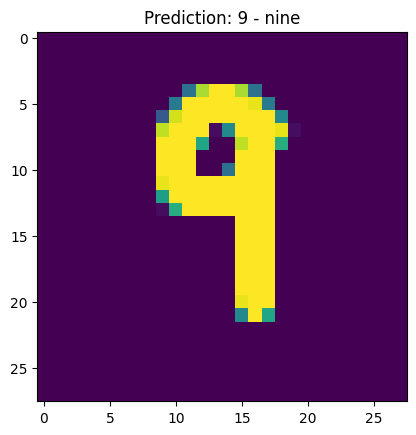

In [65]:
# classification from image that is drawn in paint.
img_path = 'MNIST_dataset/my_hand_written.png'
img = cv2.imread(img_path, 0)
tensor_img = torch.Tensor(img).unsqueeze(dim=0).unsqueeze(dim=0)
tensor_img = tensor_img.div(255)
tensor_img = tensor_img.to(device)
loaded_model.eval()
with torch.inference_mode():
    y_pred = loaded_model(tensor_img)
    y_pred = y_pred.argmax(dim=1)
plt.imshow(img)
plt.title(f'Prediction: {classes[y_pred.item()]}')

In [183]:
loaded_model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.5888,  0.1941,  0.3523],
                        [ 0.4787,  0.6659,  0.6358],
                        [-0.0395, -0.0287,  0.2382]]],
              
              
                      [[[-0.2292, -0.2590,  0.1552],
                        [-0.1094,  0.2710, -0.2397],
                        [ 0.2317,  0.0499, -0.0551]]],
              
              
                      [[[ 0.2056, -0.0715,  0.1214],
                        [ 0.1765,  0.6218,  0.5914],
                        [ 0.4216,  0.1831,  0.4006]]],
              
              
                      [[[ 0.0323,  0.4357, -0.1059],
                        [ 0.2005,  0.7790,  0.5583],
                        [-0.0222,  0.3651,  0.3066]]],
              
              
                      [[[-0.1056, -0.2690, -0.2554],
                        [ 0.1971, -0.0326,  0.1774],
                        [-0.2493,  0.2945,  0.1068]]]], device='cuda:0')),
             ('conv1.bias